[I 2025-08-15 14:53:01,954] A new study created in memory with name: no-name-ea6fc065-542e-4b30-a177-eeaad9bb5182


Using device: cuda


[I 2025-08-15 14:53:07,431] Trial 6 finished with value: 0.23451268643063403 and parameters: {'lookback': 30, 'num_layers': 2, 'hidden_size': 16, 'lr': 0.00017741339547225872, 'batch_size': 16}. Best is trial 6 with value: 0.23451268643063403.
[I 2025-08-15 14:53:09,691] Trial 0 finished with value: 0.10583268335381761 and parameters: {'lookback': 17, 'num_layers': 1, 'hidden_size': 64, 'lr': 0.00047905100414518363, 'batch_size': 16}. Best is trial 0 with value: 0.10583268335381761.
[I 2025-08-15 14:53:09,889] Trial 9 finished with value: 0.08421026859364743 and parameters: {'lookback': 17, 'num_layers': 2, 'hidden_size': 64, 'lr': 0.0011727872558736406, 'batch_size': 16}. Best is trial 9 with value: 0.08421026859364743.
[I 2025-08-15 14:53:12,137] Trial 7 finished with value: 0.08097929080246119 and parameters: {'lookback': 22, 'num_layers': 1, 'hidden_size': 16, 'lr': 0.008829698188357372, 'batch_size': 16}. Best is trial 7 with value: 0.08097929080246119.
[I 2025-08-15 14:53:13,525]

Best hyperparameters: {'lookback': 1, 'num_layers': 1, 'hidden_size': 64, 'lr': 0.00703836434684093, 'batch_size': 16}
Best validation RMSE: 0.07839315911602109
Rolling Forecast Test Metrics: {
  "MSE": 658.4130177087625,
  "RMSE": 25.6595599671694,
  "MAE": 24.73735329276637,
  "MAPE%": 38.643125017884664,
  "R2": -17.793936544364268
}


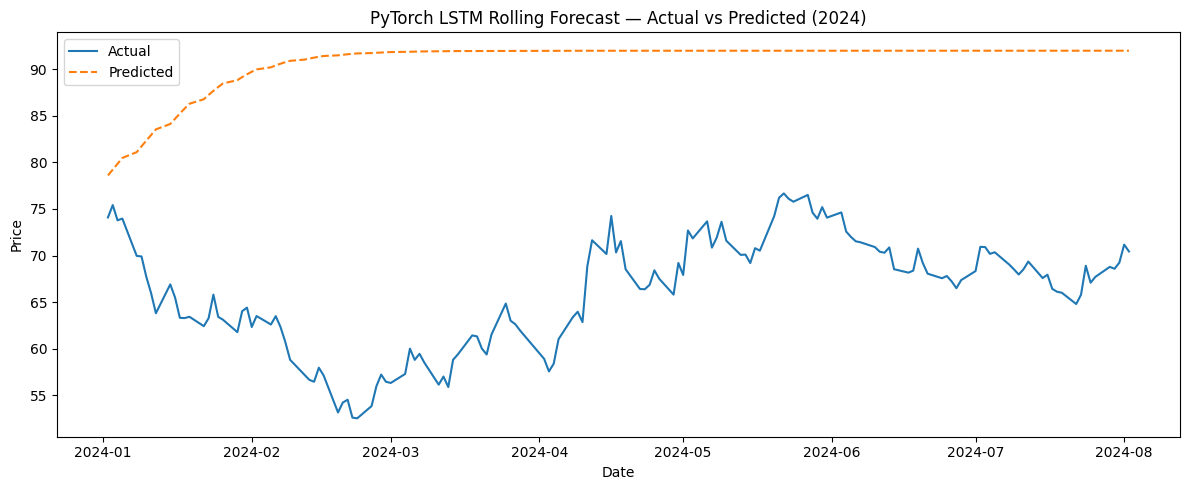

In [2]:
"""
Carbon Price Forecasting with PyTorch RNN (LSTM)
- Hyperparameters tuned via Optuna: lookback, n_layers, hidden_size, learning_rate, batch_size
- Proper scaling (train-only during tuning; train+val for final model)
- Time split: Train=2021-01-01..2023-12-31 (last 10% of that for val); Test=2024-01-01..2024-12-31
- Rolling (recursive) forecast on the 2024 test set

Requirements: pip install optuna torch scikit-learn matplotlib pandas
"""

import os
import math
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# -------------------- Config --------------------
RANDOM_STATE = 42
CSV_PATH = "Carbon_Emissions_Futures_2021_Onwards.csv"  # <--- change if needed
DATE_COL = "Date"
TARGET_COL = "Price"

# Reproducibility
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# -------------------- Data utils --------------------
def _parse_volume(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, (int, float)):
        return float(v)
    s = str(v).strip().replace(",", "")
    if s.endswith(("K","k")):
        return float(s[:-1]) * 1_000
    if s.endswith(("M","m")):
        return float(s[:-1]) * 1_000_000
    return float(s)


def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.rename(columns={"Vol.": "Volume", "Change %": "ChangePct"}, inplace=True)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], dayfirst=True, errors='coerce')
    for col in ["Price", "Open", "High", "Low"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    if "Volume" in df:
        df["Volume"] = df["Volume"].apply(_parse_volume)
    if "ChangePct" in df:
        df["ChangePct"] = pd.to_numeric(df["ChangePct"].astype(str).str.replace('%',''), errors='coerce') / 100.0
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)
    return df


def train_val_test_split(df: pd.DataFrame):
    train_mask = (df[DATE_COL] >= '2021-01-01') & (df[DATE_COL] <= '2023-12-31')
    test_mask  = (df[DATE_COL] >= '2024-01-01') & (df[DATE_COL] <= '2024-12-31')
    df_train_full = df.loc[train_mask].copy()
    df_test = df.loc[test_mask].copy()
    split_idx = int(len(df_train_full) * 0.9)
    return df_train_full.iloc[:split_idx], df_train_full.iloc[split_idx:], df_test


def create_sequences(series_2d: np.ndarray, lookback: int):
    """series_2d shape: (N, 1). Returns X: (N-lookback, lookback, 1), y: (N-lookback,).
    """
    X, y = [], []
    for i in range(lookback, len(series_2d)):
        X.append(series_2d[i-lookback:i])
        y.append(series_2d[i, 0])
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)


class SeqDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# -------------------- Model (LSTM) --------------------
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int):
        super().__init__()
        # Use nn.LSTM for Long Short-Term Memory
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.head = nn.Linear(hidden_size, 1)
    def forward(self, x):  # x: (B, T, F)
        # nn.LSTM returns (output, (h_n, c_n)), we only need the output
        out, _ = self.lstm(x)
        last = out[:, -1, :] # Use the output from the last time step
        return self.head(last).squeeze(-1)


# -------------------- Metrics --------------------
def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE%": mape, "R2": r2}


# -------------------- Training loop --------------------
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)


def eval_epoch(model, loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total += loss.item() * xb.size(0)
    return total / len(loader.dataset)


# -------------------- Main --------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 1) Load & clean
    raw = pd.read_csv(CSV_PATH)
    df = clean_dataframe(raw)

    # 2) Split
    df_train, df_val, df_test = train_val_test_split(df)

    # 3) Scale (train-only for tuning)
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(df_train[[TARGET_COL]])
    val_scaled   = scaler.transform(df_val[[TARGET_COL]])

    # -------- Optuna objective --------
    def objective(trial: optuna.Trial):
        lookback   = trial.suggest_int("lookback", 1, 30)
        num_layers = trial.suggest_int("num_layers", 1, 3)
        hidden_sz  = trial.suggest_categorical("hidden_size", [16, 32, 64, 128])
        lr         = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
        epochs     = 100

        Xtr, ytr = create_sequences(train_scaled, lookback)
        # To create validation sequences, prepend last lookback rows of train to val
        Xval_in = np.vstack([train_scaled[-lookback:], val_scaled])
        yval_in = np.concatenate([train_scaled[-lookback:,0], val_scaled[:,0]])
        Xva, yva = create_sequences(Xval_in, lookback)

        train_ds = SeqDataset(Xtr, ytr)
        val_ds   = SeqDataset(Xva, yva)
        train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_ld   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        # Use LSTMRegressor
        model = LSTMRegressor(input_size=1, hidden_size=hidden_sz, num_layers=num_layers).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        best_val = float('inf')
        patience, wait = 5, 0

        for epoch in range(epochs):
            train_epoch(model, train_ld, criterion, optimizer, device)
            val_loss = eval_epoch(model, val_ld, criterion, device)
            if val_loss < best_val - 1e-6:
                best_val = val_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    break

        return math.sqrt(best_val)  # RMSE

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200, n_jobs=-1)

    print("Best hyperparameters:", study.best_params)
    print("Best validation RMSE:", study.best_value)

    # 4) Final train on train+val with best params
    best = study.best_params
    lookback   = best["lookback"]
    num_layers = best["num_layers"]
    hidden_sz  = best["hidden_size"]
    lr         = best["lr"]
    batch_size = best["batch_size"]

    full_scaler = StandardScaler()
    trainval_scaled = full_scaler.fit_transform(pd.concat([df_train, df_val])[ [TARGET_COL] ])

    Xtrv, ytrv = create_sequences(trainval_scaled, lookback)
    trainval_ds = SeqDataset(Xtrv, ytrv)
    trainval_ld = DataLoader(trainval_ds, batch_size=batch_size, shuffle=True)

    # Use LSTMRegressor
    model_final = LSTMRegressor(input_size=1, hidden_size=hidden_sz, num_layers=num_layers).to(device)
    optimizer   = torch.optim.Adam(model_final.parameters(), lr=lr)
    criterion   = nn.MSELoss()

    EPOCHS_FINAL = 50
    for _ in range(EPOCHS_FINAL):
        train_epoch(model_final, trainval_ld, criterion, optimizer, device)

    # 5) Rolling forecast on test set (recursive, on scaled values)
    history = trainval_scaled.tolist()  # list of [scaled_price]
    preds_scaled = []
    with torch.no_grad():
        for _ in range(len(df_test)):
            x_in = np.array(history[-lookback:]).reshape(1, lookback, 1).astype(np.float32)
            x_tensor = torch.from_numpy(x_in).to(device)
            yhat = model_final(x_tensor).cpu().numpy().ravel()[0]
            preds_scaled.append(yhat)
            history.append([yhat])  # append predicted (scaled) value for next step

    preds = full_scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).ravel()

    # 6) Metrics & Plot
    y_test = df_test[TARGET_COL].values
    metrics = evaluate_metrics(y_test, preds)
    print("Rolling Forecast Test Metrics:", json.dumps(metrics, indent=2))

    plt.figure(figsize=(12,5))
    plt.plot(df_test[DATE_COL], y_test, label='Actual')
    plt.plot(df_test[DATE_COL], preds, label='Predicted', linestyle='--')
    plt.title('PyTorch LSTM Rolling Forecast — Actual vs Predicted (2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Save best params for reproducibility
    # with open('best_lstm_params.json', 'w') as f:
    #     json.dump({"best_params": study.best_params, "best_val_rmse": study.best_value}, f, indent=2)
    # print("Saved best params to best_lstm_params.json")

[I 2025-08-15 18:10:19,706] A new study created in memory with name: no-name-79c8c470-de5a-4de0-9c11-8f2be3405720


Using device: cuda


[I 2025-08-15 18:10:23,310] Trial 0 finished with value: 0.08055603002021806 and parameters: {'lookback': 23, 'num_layers': 1, 'hidden_size': 46, 'lr': 0.004515332002434707, 'batch_size': 16}. Best is trial 0 with value: 0.08055603002021806.
[I 2025-08-15 18:10:27,140] Trial 1 finished with value: 0.08268315416652915 and parameters: {'lookback': 5, 'num_layers': 2, 'hidden_size': 79, 'lr': 0.0026261413299248706, 'batch_size': 16}. Best is trial 0 with value: 0.08055603002021806.
[I 2025-08-15 18:10:29,589] Trial 2 finished with value: 0.08337109730984693 and parameters: {'lookback': 13, 'num_layers': 2, 'hidden_size': 68, 'lr': 0.0021084848840404414, 'batch_size': 32}. Best is trial 0 with value: 0.08055603002021806.
[I 2025-08-15 18:10:30,092] Trial 3 finished with value: 0.15771178427073573 and parameters: {'lookback': 5, 'num_layers': 1, 'hidden_size': 25, 'lr': 0.0010454080149625898, 'batch_size': 32}. Best is trial 0 with value: 0.08055603002021806.
[I 2025-08-15 18:10:30,900] Tri

Best hyperparameters: {'lookback': 3, 'num_layers': 1, 'hidden_size': 103, 'lr': 0.008174641226179245, 'batch_size': 16}
Best validation RMSE: 0.07859023218463493
Multi-step Rolling Forecast (1-day blocks) Test Metrics: {
  "MSE": 3.459868991759672,
  "RMSE": 1.8600723082073105,
  "MAE": 1.5053463674846455,
  "MAPE%": 2.2885263473292072,
  "R2": 0.9012404728733548
}
Saved plot to lstm_pytorch_multistep_forecast_2024.png
Saved best params to best_lstm_params_multistep.json


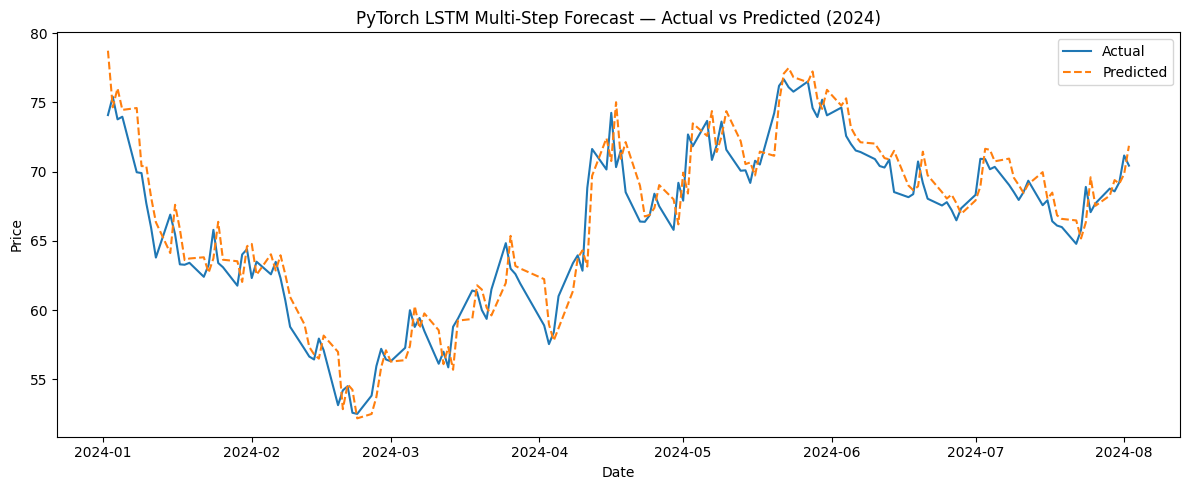

In [4]:
"""
Modified: Carbon Price Forecasting with PyTorch LSTM
- Multi-step Rolling Forecast (5 steps) on Test Set.
- The model predicts 5 days at a time. The ground truth is used to advance the window.
"""

import os
import math
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import optuna

# -------------------- Config --------------------
RANDOM_STATE = 42
CSV_PATH = "Carbon_Emissions_Futures_2021_Onwards.csv"
DATE_COL = "Date"
TARGET_COL = "Price"
FORECAST_STEPS = 1 # Number of steps to forecast ahead

# Reproducibility
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# -------------------- Data utils --------------------
def _parse_volume(v):
    if pd.isna(v):
        return np.nan
    if isinstance(v, (int, float)):
        return float(v)
    s = str(v).strip().replace(",", "")
    if s.endswith(("K","k")):
        return float(s[:-1]) * 1_000
    if s.endswith(("M","m")):
        return float(s[:-1]) * 1_000_000
    return float(s)

def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.rename(columns={"Vol.": "Volume", "Change %": "ChangePct"}, inplace=True)
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], dayfirst=True, errors='coerce')
    for col in ["Price", "Open", "High", "Low"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    if "Volume" in df:
        df["Volume"] = df["Volume"].apply(_parse_volume)
    if "ChangePct" in df:
        df["ChangePct"] = pd.to_numeric(df["ChangePct"].astype(str).str.replace('%',''), errors='coerce') / 100.0
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)
    return df

def train_val_test_split(df: pd.DataFrame):
    train_mask = (df[DATE_COL] >= '2021-01-01') & (df[DATE_COL] <= '2023-12-31')
    test_mask  = (df[DATE_COL] >= '2024-01-01') & (df[DATE_COL] <= '2024-12-31')
    df_train_full = df.loc[train_mask].copy()
    df_test = df.loc[test_mask].copy()
    split_idx = int(len(df_train_full) * 0.9)
    return df_train_full.iloc[:split_idx], df_train_full.iloc[split_idx:], df_test

def create_sequences(series_2d: np.ndarray, lookback: int):
    X, y = [], []
    for i in range(lookback, len(series_2d)):
        X.append(series_2d[i-lookback:i])
        y.append(series_2d[i, 0])
    return np.asarray(X, dtype=np.float32), np.asarray(y, dtype=np.float32)

class SeqDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# -------------------- Model --------------------
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.head = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.head(last).squeeze(-1)

# -------------------- Metrics --------------------
def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "MAPE%": mape, "R2": r2}

# -------------------- Training loop --------------------
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            total += loss.item() * xb.size(0)
    return total / len(loader.dataset)

# -------------------- Main --------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    raw = pd.read_csv(CSV_PATH)
    df = clean_dataframe(raw)
    df_train, df_val, df_test = train_val_test_split(df)
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(df_train[[TARGET_COL]])
    val_scaled   = scaler.transform(df_val[[TARGET_COL]])

    def objective(trial: optuna.Trial):
        lookback   = trial.suggest_int("lookback", 2, 30)
        num_layers = trial.suggest_int("num_layers", 1, 3)
        hidden_sz  = trial.suggest_int("hidden_size", 16, 128, log=True)
        lr         = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
        epochs     = 100

        Xtr, ytr = create_sequences(train_scaled, lookback)
        Xval_in = np.vstack([train_scaled[-lookback:], val_scaled])
        yval_in = np.concatenate([train_scaled[-lookback:,0], val_scaled[:,0]])
        Xva, yva = create_sequences(Xval_in, lookback)

        train_ds = SeqDataset(Xtr, ytr)
        val_ds   = SeqDataset(Xva, yva)
        train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_ld   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

        model = LSTMRegressor(input_size=1, hidden_size=hidden_sz, num_layers=num_layers).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        best_val = float('inf')
        patience, wait = 5, 0
        for epoch in range(epochs):
            train_epoch(model, train_ld, criterion, optimizer, device)
            val_loss = eval_epoch(model, val_ld, criterion, device)
            if val_loss < best_val - 1e-6:
                best_val = val_loss
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    break
        return math.sqrt(best_val)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    print("Best hyperparameters:", study.best_params)
    print("Best validation RMSE:", study.best_value)

    best = study.best_params
    lookback   = best["lookback"]
    num_layers = best["num_layers"]
    hidden_sz  = best["hidden_size"]
    lr         = best["lr"]
    batch_size = best["batch_size"]

    full_scaler = StandardScaler()
    trainval_scaled = full_scaler.fit_transform(pd.concat([df_train, df_val])[ [TARGET_COL] ])
    Xtrv, ytrv = create_sequences(trainval_scaled, lookback)
    trainval_ds = SeqDataset(Xtrv, ytrv)
    trainval_ld = DataLoader(trainval_ds, batch_size=batch_size, shuffle=True)
    model_final = LSTMRegressor(input_size=1, hidden_size=hidden_sz, num_layers=num_layers).to(device)
    optimizer   = torch.optim.Adam(model_final.parameters(), lr=lr)
    criterion   = nn.MSELoss()

    EPOCHS_FINAL = 50
    for _ in range(EPOCHS_FINAL):
        train_epoch(model_final, trainval_ld, criterion, optimizer, device)

    # -------------------- Multi-step rolling forecast loop (MODIFIED) --------------------
    history = trainval_scaled.tolist()
    preds_scaled = []
    y_test_scaled = full_scaler.transform(df_test[[TARGET_COL]]).tolist()

    with torch.no_grad():
        for i in range(0, len(df_test), FORECAST_STEPS):
            # A) Make multi-step predictions based on current history
            temp_history = history.copy()
            block_preds = []
            for _ in range(FORECAST_STEPS):
                x_in = np.array(temp_history[-lookback:]).reshape(1, lookback, 1).astype(np.float32)
                x_tensor = torch.from_numpy(x_in).to(device)
                yhat = model_final(x_tensor).cpu().numpy().ravel()[0]
                block_preds.append(yhat)
                temp_history.append([yhat]) # Use prediction for the next step within the block
            
            preds_scaled.extend(block_preds)

            # B) Advance the window using ground truth
            for j in range(FORECAST_STEPS):
                if i + j < len(df_test):
                    history.append(y_test_scaled[i + j])
                else:
                    break
    
    preds_scaled = preds_scaled[:len(df_test)]

    preds = full_scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).ravel()

    # -------------------- Metrics & Plot --------------------
    y_test = df_test[TARGET_COL].values
    metrics = evaluate_metrics(y_test, preds)
    print("Multi-step Rolling Forecast (1-day blocks) Test Metrics:", json.dumps(metrics, indent=2))

    plt.figure(figsize=(12,5))
    plt.plot(df_test[DATE_COL], y_test, label='Actual')
    plt.plot(df_test[DATE_COL], preds, label='Predicted', linestyle='--')
    plt.title('PyTorch LSTM Multi-Step Forecast — Actual vs Predicted (2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.tight_layout()
    plt.savefig('lstm_pytorch_multistep_forecast_2024.png', dpi=150)
    print("Saved plot to lstm_pytorch_multistep_forecast_2024.png")

    with open('best_lstm_params_multistep.json', 'w') as f:
        json.dump({"best_params": study.best_params, "best_val_rmse": study.best_value}, f, indent=2)
    print("Saved best params to best_lstm_params_multistep.json")